In [1]:
import numpy as np
import polytope
import controlpy
import control_utils
import uncertainty_utils
import matplotlib.pyplot as plt
import scipy.spatial
import time

## Check instantiation, vertex representation, equality

In [2]:
A = np.array([[1, 1], [-1,0], [0,1], [0,-1], [.9,.5]])
b = np.ones(A.shape[0])
p = polytope.Polytope(A,b)

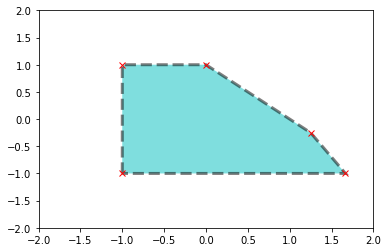

In [3]:
plt.figure()
ax = plt.gca()
plt.xlim((-2,2))
plt.ylim((-2,2))
points = polytope.extreme(p)
p.plot(ax=ax, color="c", alpha=0.5)
plt.plot(points[:,0], points[:,1], "rx")

True

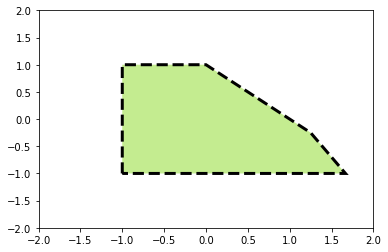

In [4]:
plt.figure()
ax = plt.gca()
plt.xlim((-2,2))
plt.ylim((-2,2))
q = polytope.qhull(points)
q.plot(ax =ax)
p == q

## Check transformation function

In [5]:
theta = np.pi/4
G = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
p_rot = control_utils.poly_transform(p, G)

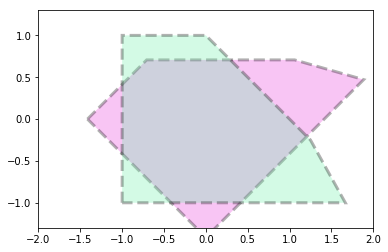

In [6]:
plt.figure()
plt.axis("equal")
ax = plt.gca()
plt.xlim((-2,2))
plt.ylim((-2,2))
p_rot.plot(ax=ax, alpha=0.3)
p.plot(ax=ax, alpha=0.3)

## Check translation function

In [7]:
z = np.array([3, 1])
p_translated = control_utils.poly_translate(p, z)

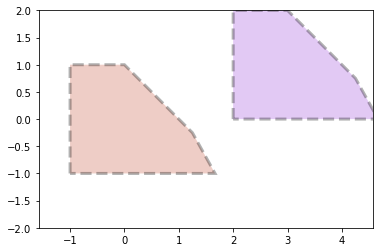

In [8]:
plt.figure()
plt.axis("equal")
ax = plt.gca()
plt.xlim((-2,5))
plt.ylim((-2,2))
p_translated.plot(ax=ax, alpha=0.3)
p.plot(ax=ax, alpha=0.3)

## Check minkowski sum function

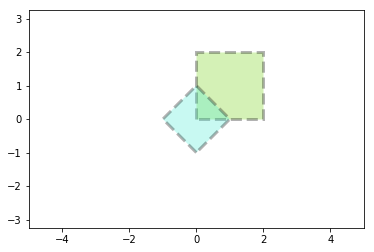

In [9]:
alpha = 0.3
xlims = (-5,5)
ylims = xlims
p_points = np.array([[0,0], [2,0], [0,2], [2,2]])
q_points = np.array([[1,0], [-1,0], [0,1], [0,-1]])
p = polytope.qhull(p_points)
q = polytope.qhull(q_points)
plt.figure()
plt.axis("equal")
ax = plt.gca()
plt.xlim(xlims)
plt.ylim(ylims)
p.plot(ax=ax, alpha=alpha)
q.plot(ax=ax, alpha=alpha)

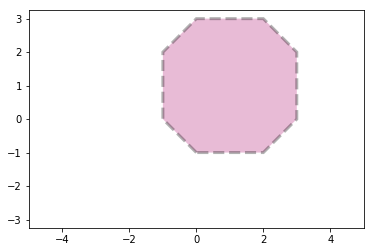

In [10]:
s = control_utils.minkowski_sum(p,q)
plt.figure()
plt.axis("equal")
ax = plt.gca()
plt.xlim(xlims)
plt.ylim(ylims)
s.plot(ax=ax, alpha=alpha)

## Check Pontryagin Difference Function

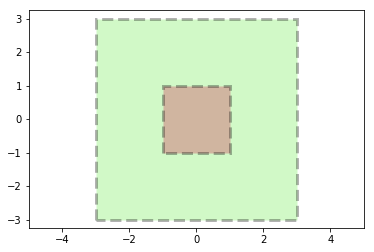

In [11]:
q = polytope.box2poly([[-1,1],[-1,1]])
p = polytope.box2poly([[-3,3],[-3,3]])
# q = control_utils.poly_transform(q, G)
# p = polytope.qhull(p_points)

xlims = (-5,5)
ylims = xlims
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.xlim(xlims)
plt.ylim(ylims)

p.plot(ax=ax, alpha=alpha)
q.plot(ax=ax, alpha=alpha)

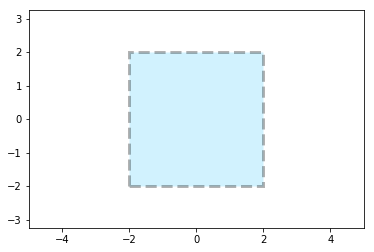

In [12]:
s = control_utils.pontryagin_difference(p, q)
plt.figure()
plt.axis("equal")
ax = plt.gca()
plt.xlim(xlims)
plt.ylim(ylims)
s.plot(ax=ax, alpha=alpha)

## Check Autonomous Pre function

In [13]:
A = np.array([[1,.5],[0,1]])
B = np.array([0,1]).reshape((2,1))
K, _, _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, np.eye(2), 1)
A_clp = A - B @ K
p = polytope.box2poly([[-1,1], [-1,1]])
ps = [p]
for i in range(2):
    ps.append(control_utils.autonomous_pre(ps[-1], A_clp))

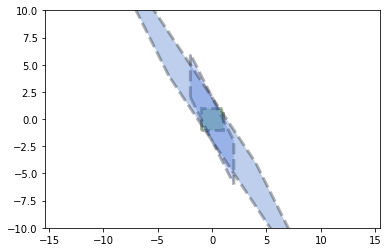

In [14]:
xlims = (-10,10)
ylims = xlims
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.xlim(xlims)
plt.ylim(ylims)
for pt in ps:
    pt.plot(ax=ax, alpha=0.3)

In [15]:
pre = ps[1]
x_range = np.linspace(-5,5, 100)
y_range = x_range
correct = True
for x in x_range:
    for y in y_range:
        pt = np.array([x,y])
        if (pt in pre) != ((A_clp @ pt) in p):
            correct = False
            break
print(correct)

True


## Check robust autonomous Pre function

In [16]:
p = polytope.box2poly([[-3,3],[-3,3]])
w = polytope.box2poly([[-1,1],[-1,1]])
pre = control_utils.autonomous_pre(p, A_clp)
rpre = control_utils.robust_autonomous_pre(p, w, A_clp)

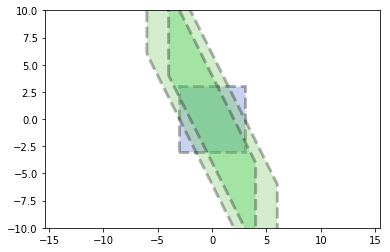

In [17]:
xlims = (-10,10)
ylims = xlims
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.xlim(xlims)
plt.ylim(ylims)
p.plot(ax=ax, alpha=0.3)
pre.plot(ax=ax, alpha=0.3)
rpre.plot(ax=ax, alpha=0.3)

In [18]:
x_range = np.linspace(-5,5, 100)
y_range = x_range
correct = True
for x in x_range:
    for y in y_range:
        pt = np.array([x,y])
        if (pt in rpre) != polytope.is_subset(control_utils.poly_translate(w, A_clp @ pt), p):
            correct = False
            break           
print(correct)

True


## Test Maximal Invariant

In [19]:
X = polytope.box2poly([[-5,5],[-5,5]])
O = control_utils.maximal_invariant(X, A_clp)

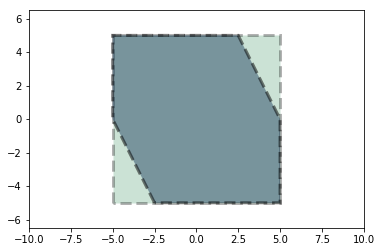

In [20]:
xlims = (-10,10)
ylims = xlims
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.xlim(xlims)
plt.ylim(ylims)
X.plot(ax=ax, alpha=0.3)
O.plot(ax=ax, alpha=0.5)

In [21]:
x_range = np.linspace(-5,5, 100)
y_range = x_range
correct = True
for x in x_range:
    for y in y_range:
        pt = np.array([x,y])
        if (pt in O) != ((A_clp @ pt) in O):
            correct = False
            break
print(correct)

True


## Check Minimal Invariant

In [22]:
W = polytope.box2poly([[-.5,.5],[-.5,.5]])
M = control_utils.minimal_invariant(A_clp, W)
print(control_utils.is_robust_invariant(M, W, A_clp))

True


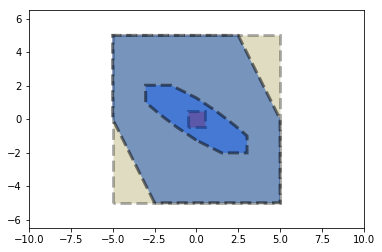

In [23]:
xlims = (-10,10)
ylims = xlims
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.xlim(xlims)
plt.ylim(ylims)
X.plot(ax=ax, alpha=0.3)
O.plot(ax=ax, alpha=0.5)
W.plot(ax=ax, alpha=0.5)
M.plot(ax=ax, alpha=0.5)

## Test is robust maximal invariant

In [24]:
X = polytope.box2poly([[-5,5],[-5,5]])
RO_nominal, RO_total = control_utils.robust_maximal_invariant(X, W, M, A_clp)
print(control_utils.is_invariant(RO_nominal, A_clp))
print(control_utils.is_robust_invariant(RO_total, W, A_clp))

True
True


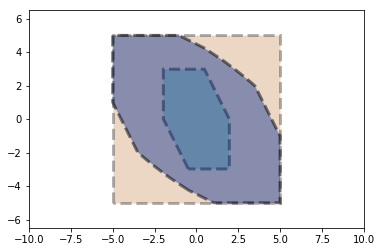

In [25]:
xlims = (-10,10)
ylims = xlims
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.xlim(xlims)
plt.ylim(ylims)
X.plot(ax=ax, alpha=0.3)
# M.plot(ax=ax, alpha=0.5)
RO_nominal.plot(ax=ax, alpha=0.5)
RO_total.plot(ax=ax, alpha=0.5)

## Check with Input Constraints

In [26]:
U = polytope.qhull(np.array([-3,3]).reshape((2,1)))
M_u = control_utils.poly_transform(M, K)
U_bar = control_utils.pontryagin_difference(U, M_u)
print(M_u)

Single polytope 
  [[ 1.] x <= [[1.26405]
   [-1.]]|     [1.26226]]



In [27]:
RO_nominal, RO_total = control_utils.robust_maximal_invariant(X, W, M, A,
                                                              B=B, K=K, U=U)

In [28]:
print(control_utils.is_invariant(RO_nominal, A, B=B, K=K, U=U_bar))
print(control_utils.is_robust_invariant(RO_total, W, A, B=B, K=K, U=U))

True
True


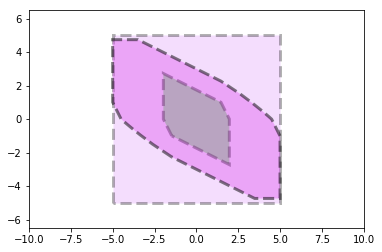

In [29]:
xlims = (-10,10)
ylims = xlims
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.xlim(xlims)
plt.ylim(ylims)
X.plot(ax=ax, alpha=0.3)
# M.plot(ax=ax, alpha=0.5)
RO_nominal.plot(ax=ax, alpha=0.5)
RO_total.plot(ax=ax, alpha=0.5)

## Compare scipy convexhull

In [30]:
n = 100
d = 3
data = np.random.rand(n, d)

In [31]:
t1 = time.time()
p1 = polytope.qhull(data)
t2 = time.time()
print(t2 - t1)

0.0782172679901123


In [32]:
t1 = time.time()
chull = scipy.spatial.ConvexHull(data)
t2 = time.time()
print(t2 - t1)
t1 = time.time()
p2 = polytope.Polytope(chull.equations[:,:-1], -chull.equations[:,-1])
t2 = time.time()
print(t2-t1)

0.002993345260620117
0.0009963512420654297


In [33]:
# plt.figure()
# ax = plt.gca()
# p1.project([1,2]).plot(ax=ax)
# plt.figure()
# ax = plt.gca()
# p2.project([1,2]).plot(ax=ax)

In [34]:
p3 = p1.diff(p2)
p3.volume

0.0

In [35]:
t1 = time.time()
polytope.extreme(p2)
t2 = time.time()
print(t2-t1)
chull.vertices.shape

0.13797760009765625


(35,)

In [36]:
p2.vertices = chull.points[chull.vertices,:]

In [37]:
t1 = time.time()
polytope.projection(p2, [1,2], solver="exthull")
t2 = time.time()
print(t2-t1)

0.012965917587280273


## Test Pontryagin Difference for hyper-ellipsoids

In [38]:
A_poly = polytope.box2poly([[-2,2],[-2,2]])
B_poly = polytope.box2poly([[-1,1],[-1,1]])
B_ell = np.eye(2)

(-3, 3)

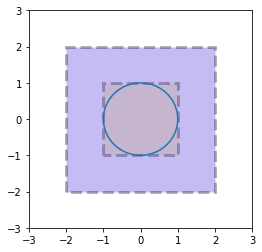

In [39]:
lims = (-3,3)
plt.figure(figsize=(4,4))
ax = plt.gca()
B_poly.plot(ax=ax, alpha=0.3)
A_poly.plot(ax=ax, alpha=0.3)
ellipse = uncertainty_utils.get_elipse(1, B_ell, np.zeros(2))
plt.plot(ellipse[:,0], ellipse[:,1])
# plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)

In [40]:
A_poly_diff = control_utils.pontryagin_difference(A_poly, B_poly)
A_ell_diff = control_utils.pontryagin_difference(A_poly, B_ell)
B_transf = control_utils.poly_transform(B_poly, G)
A_rot_diff = control_utils.pontryagin_difference(A_poly, B_transf)

In [41]:
print(A_poly_diff == A_ell_diff)
print(A_rot_diff == A_ell_diff)

True
False


## Test Invariance of Probabilistic Minimal Invariant

Text(0.5,1,'Disturbance Set')

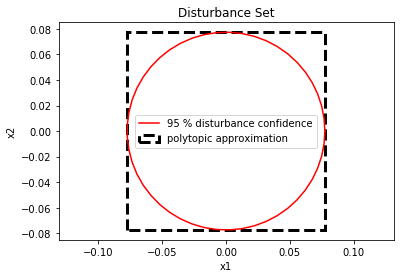

In [48]:
process_noise_var = 1e-3
N = 2
process_noise = process_noise_var * np.eye(N)
conf = 0.95
t = uncertainty_utils.calc_t(0.95, N)
disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(N))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db],[-db, db]])
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.plot(disturbance_set[:,0], disturbance_set[:,1], color="r")
disturbance_bound.plot(ax=ax, alpha=1, color="w", edgecolor="k")
plt.legend(("95 % disturbance confidence", "polytopic approximation"))
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Disturbance Set")

In [49]:
minimal_invariant_covariance = scipy.linalg.solve_discrete_lyapunov(A - B @ K, process_noise) * (t ** 2)

In [52]:
samples = 30000
length = 1000
inv_val = np.linalg.inv(minimal_invariant_covariance)
correct = True
invariant_num = 0
A_clp = A - B @ K
for i in range(samples):
    x = np.zeros(2)
    dists = np.random.multivariate_normal(np.zeros(N), process_noise, size=length)
    for w in np.rollaxis(dists, 0):
        x = A_clp @ x + w
    invariant_num += x.T @ inv_val @ x <=1
    
print("true confidence = %f, estimated confidence = %f" % (conf, invariant_num / samples))

true confidence = 0.950000, estimated confidence = 0.948933
